In [1]:
import cv2 as cv
import numpy as np
import math
import os 
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
# Open img
img = cv.imread('/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Testfotos/kaderscheef.jpg')
kopie = img.copy()








In [2]:
BASE_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN'
DATA_PATH = os.path.sep.join([BASE_PATH, "Trimmeddata_bigger_test"])
VAL_IMAGES_PATH = os.path.sep.join([DATA_PATH, "test/images"])

VAL_IMAGES_PATH ='/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/typevoorbeelden'

print(VAL_IMAGES_PATH)
VAL_ANNOTS_PATH = os.path.sep.join([DATA_PATH, "test/_annotations.csv"])
print(VAL_ANNOTS_PATH)

/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/typevoorbeelden
/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/CustCNN/Trimmeddata_bigger_test/test/_annotations.csv


In [3]:
def getpoints(img):
    #img = cv.resize(img, (500, 500), interpolation = cv.INTER_AREA)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)

    #Canny edge detection
    canny = cv.Canny(blurred, 5, 20, 1)

    # Find contours
    cnts = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Iterate trough contours and find the biggest fitted rectangle
    maxArea = 0
    for c in cnts:
        area = cv.contourArea(c)
        if(area > maxArea):
            maxC=c
            maxArea = area


    # Draw found contour        
    #cv.drawContours(kopie, maxC, -1, (0, 255, 0), 3)        

    # Draw rectangle
    x,y,w,h = cv.boundingRect(maxC)
    
    
    xmin = x
    ymin = y
    xmax = x+w
    ymax = y+h
    
    cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    # Draw circle
    center, radius = cv.minEnclosingCircle(maxC)
    cv.circle(img, (int(center[0]), int(center[1])), int(radius), (0, 255, 0), 2)      

    # Print Centre and radius    
    print('center of frame:', center)
    print('radius of smallest fitted circle:', radius)
    #cv.imshow('rectangle & circle', img)
    #cv.waitKey(0)
    #cv.imshow('canny', canny)
    #cv.imshow('rectangle & circle', img)
    #cv.waitKey(0)
    return xmin, ymin, xmax, ymax,canny

    
    """cv.imshow('blurred', blurred)
    cv.imshow('canny', canny)
    cv.imshow('found contour', kopie)
    cv.imshow('rectangle & circle', img)
    cv.imwrite('gray.png', gray)
    cv.imwrite('blurred.png', blurred)
    cv.imwrite('canny.png', canny)
    cv.imwrite('img.png', img)
    cv.imwrite('contour.png', kopie)
    cv.waitKey(0)"""

In [4]:
#annotaties inladen

df=pd.read_csv(VAL_ANNOTS_PATH)
df = df.drop('class', axis=1)
df = df.drop('width', axis=1)
df = df.drop('height', axis=1)
df.head(5)

,filename,xmin,ymin,xmax,ymax
0,293e442438ebe3ae_jpg.rf.059af780b38cffec097999...,43,15,364,386
1,aa05dbe467400fbf_jpg.rf.136993704d04fdc6fb5c1b...,122,111,327,330
2,5c826816c70b0dec_jpg.rf.0629a7cbfa16af730e7f8b...,27,33,397,348
3,d32442c4e0c75b88_jpg.rf.073165b8c2896e53bc7843...,82,42,346,385
4,42ae41305ec3108f_jpg.rf.02a502233a61a91272a6bd...,75,3,349,369


In [5]:

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou




In [10]:
import time

tijden=0
ious = []
i=0
PRED_PATH = os.path.sep.join([BASE_PATH, 'predictions'])
PRED_PATH = '/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/Resultaten/OpenCV/typeset/Annotations'
for filename in os.listdir(VAL_IMAGES_PATH):
    i += 1
    
    image_path =  os.path.sep.join([VAL_IMAGES_PATH,filename])
    
    if filename != '.DS_Store':
        print("foto nr: ",i)
        img = cv.imread(image_path)
        kopie = img.copy()
        
        
        begin = time.time()
        xmin, ymin, xmax, ymax,edges = getpoints(kopie)
        end = time.time()
        #print(end-begin)
        tijden += (end - begin)
        
        
        #prediction omzetten naar correcte grootte
        


        image = cv.imread(image_path)
        #bounding box tekenen op foto 
        #TODO aanpassen voor meerdere per foto
        

        row = df.loc[df['filename'] == filename]
        row = row.to_numpy()
        if row.size != 0:
            startX = (row[0][1])
            startY = (row[0][2])
            endX= (row[0][3])
            endY= (row[0][4])
        
        box_1 = [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
        box_2 = [[startX, startY], [endX, startY], [endX, endY], [startX, endY]]

        iou = 0
        iou=calculate_iou(box_1, box_2)
        iou = (round(iou, 2))
        ious.append(iou)
        cv.rectangle(image, (int(startX), int(startY)), (int(endX), int(endY)),(0, 0, 255), 2)
        cv.rectangle(image, (xmin, ymin), (xmax, ymax),(0, 255, 0), 2)
        
        cv.rectangle(image, (xmin,ymin+20), (xmin+70, ymin), (0,255,0), -1)
        cv.putText(img=image,text=('IOU: '+str(iou)), org=(xmin+5, ymin+15), fontFace=cv.FONT_HERSHEY_DUPLEX , fontScale=0.4, color=(0, 0, 0),thickness=1) 

            #print(int(startX), int(startY), int(endX), int(endY))
        
            #write output naar predictions map

        filenameB = str(i)+'.jpg'

        path ='/Users/stefgielen/Documents/school 2021-2022/thesis/Python_Workspace/Resultaten/OpenCV/typeset/Images'
        cv.imwrite(os.path.join(path , filenameB), image)
        
        annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.txt')])
        file = open(annotation_path, 'w')
        file.write( " ".join(['Picture-frame', "1", str(xmin),  str(ymin), str(xmax), str(ymax)]))
        
        filename = str(i)+'_edges'+'.jpg'
        cv.imwrite(os.path.join(path , filename), edges)

        """
        if VOC:
            annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.xml')])
            writer = Writer(filename, w, h)

            # add objects (class, xmin, ymin, xmax, ymax)
            writer.addObject('Picture-frame', xmin, ymin, xmax, ymax)
            # write to file
            writer.save(annotation_path)"""

       
annotation_path =  os.path.sep.join([PRED_PATH,(os.path.splitext(filename)[0]+'.txt')])
file = open(annotation_path, 'w')
file.write( " ".join(['Picture-frame', "1", str(xmin),  str(ymin), str(xmax), str(ymax)]))

tijden = tijden/i           
print(tijden)



foto nr:  1
center of frame: (205.72628784179688, 236.63626098632812)
radius of smallest fitted circle: 211.07217407226562
foto nr:  2
center of frame: (241.84017944335938, 194.46519470214844)
radius of smallest fitted circle: 211.19827270507812
foto nr:  3
center of frame: (203.0, 345.0)
radius of smallest fitted circle: 125.03609466552734
foto nr:  4
center of frame: (215.5, 208.0)
radius of smallest fitted circle: 141.34454345703125
foto nr:  5
center of frame: (214.0, 83.0)
radius of smallest fitted circle: 139.01449584960938
foto nr:  7
center of frame: (340.8404846191406, 261.65008544921875)
radius of smallest fitted circle: 32.19113540649414
foto nr:  8
center of frame: (184.01609802246094, 217.6931915283203)
radius of smallest fitted circle: 164.74508666992188
foto nr:  9
center of frame: (51.0, 93.0)
radius of smallest fitted circle: 47.539554595947266
foto nr:  10
center of frame: (234.5542755126953, 197.6513671875)
radius of smallest fitted circle: 209.1255340576172
foto nr:

24


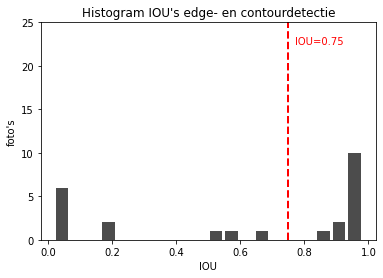

In [7]:
print(len(ious))
ious = np.array(ious)
plt.title("Histogram IOU's edge- en contourdetectie")
plt.xlabel("IOU")
plt.ylabel("foto's")
plt.hist(x=ious, bins=20, color='#000000',
                            alpha=0.7, rwidth=0.8)
plt.axvline(0.75, color='r', linestyle='dashed', linewidth=2)
plt.text(0.77, 25*0.9, 'IOU=0.75',color='r')
plt.ylim(ymin=0, ymax = 25)
plt.show() 